# Preparation

In [64]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales_train = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dayfirst=True)
sample_submission = pd.read_csv('data/sample_submission.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Augment data
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year
sales_train['weekday'] = sales_train['date'].dt.day_of_week + 1
sales_train['total_price'] = sales_train['item_cnt_day'] * sales_train['item_price']
sales_train = pd.merge(sales_train, items[['item_id', 'item_category_id']], on='item_id')

# Basic statistics

c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


5 lowest item_cnt_day:
        date  shop_id  item_id   item_price  item_cnt_day  \
0 2013-11-02       12     8023    15.000000         -22.0   
1 2014-07-10       14    20949     5.000000         -16.0   
2 2014-10-10       12     9242  1433.333333          -9.0   
3 2013-01-18       12     1590  2599.000000          -6.0   
4 2013-10-19       42     3732  2599.000000          -6.0   

                                           item_name  
0         ZL004 Лазерные наклейки Смайлики маленькие  
1  Фирменный пакет майка 1С Интерес белый (34*42)...  
2  Билет "ИгроМир 2014" (на один день (отдельно -...  
3  Assassin’s Creed 3. Freedom Edition [PC, русск...  
4         Grand Theft Auto V [PS3, русские субтитры]  
5 highest item_cnt_day:
        date  shop_id  item_id   item_price  item_cnt_day  \
0 2015-10-28       12    11373     0.908714        2169.0   
1 2015-01-15       12    20949     4.000000        1000.0   
2 2015-09-30       12     9248  1692.526158         669.0   
3 2015-09-30

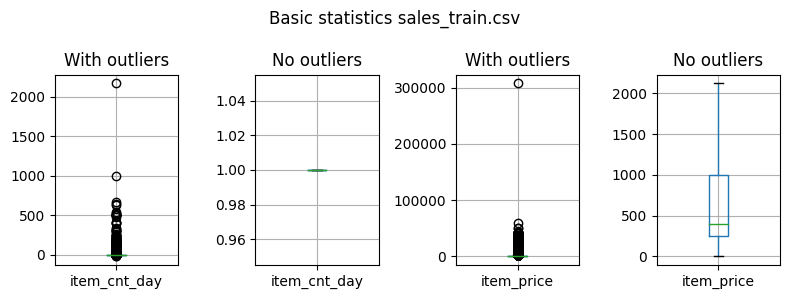

In [44]:
fig, axs = plt.subplots(1,4, figsize=(8,3))
sales_train.boxplot('item_cnt_day', ax=axs[0])
axs[0].set_title('With outliers')
sales_train.boxplot('item_cnt_day', ax=axs[1], showfliers=False)
axs[1].set_title('No outliers')
sales_train.boxplot('item_price', ax=axs[2])
axs[2].set_title('With outliers')
sales_train.boxplot('item_price', ax=axs[3], showfliers=False)
axs[3].set_title('No outliers')
fig.suptitle('Basic statistics sales_train.csv')
fig.tight_layout(rect=[0,0,1,1])
fig.show()

lowest_cnt = sales_train.sort_values('item_cnt_day', ascending=True).head(5)
lowest_cnt = lowest_cnt.merge(items, on='item_id')[['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name']]
print("5 lowest item_cnt_day:")
print(lowest_cnt)

highest_cnt = sales_train.sort_values('item_cnt_day', ascending=False).head(5)
highest_cnt = highest_cnt.merge(items, on='item_id')[['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name']]
print("5 highest item_cnt_day:")
print(highest_cnt)

lowest_price = sales_train.sort_values('item_price', ascending=True).head(5)
lowest_price = lowest_price.merge(items, on='item_id')[['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name']]
print("5 lowest item_price:")
print(lowest_price)

highest_price = sales_train.sort_values('item_price', ascending=False).head(5)
highest_price = highest_price.merge(items, on='item_id')[['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name']]
print("5 highest item_price:")
print(highest_price)

# Investigating shops/items

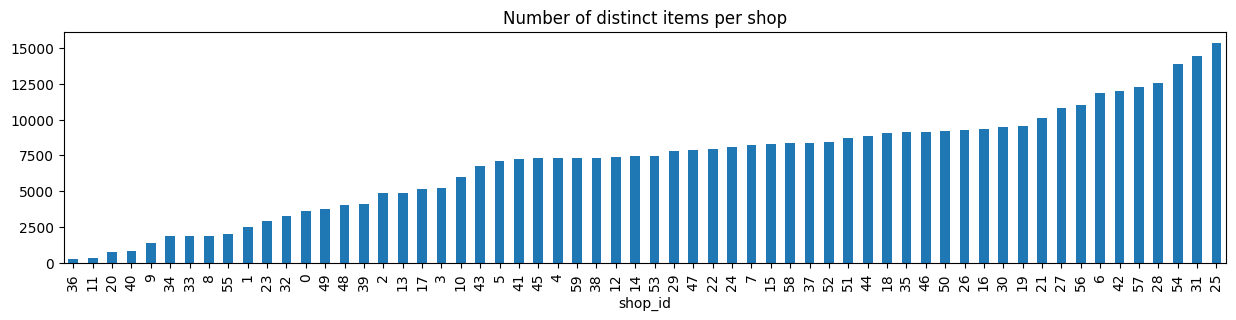

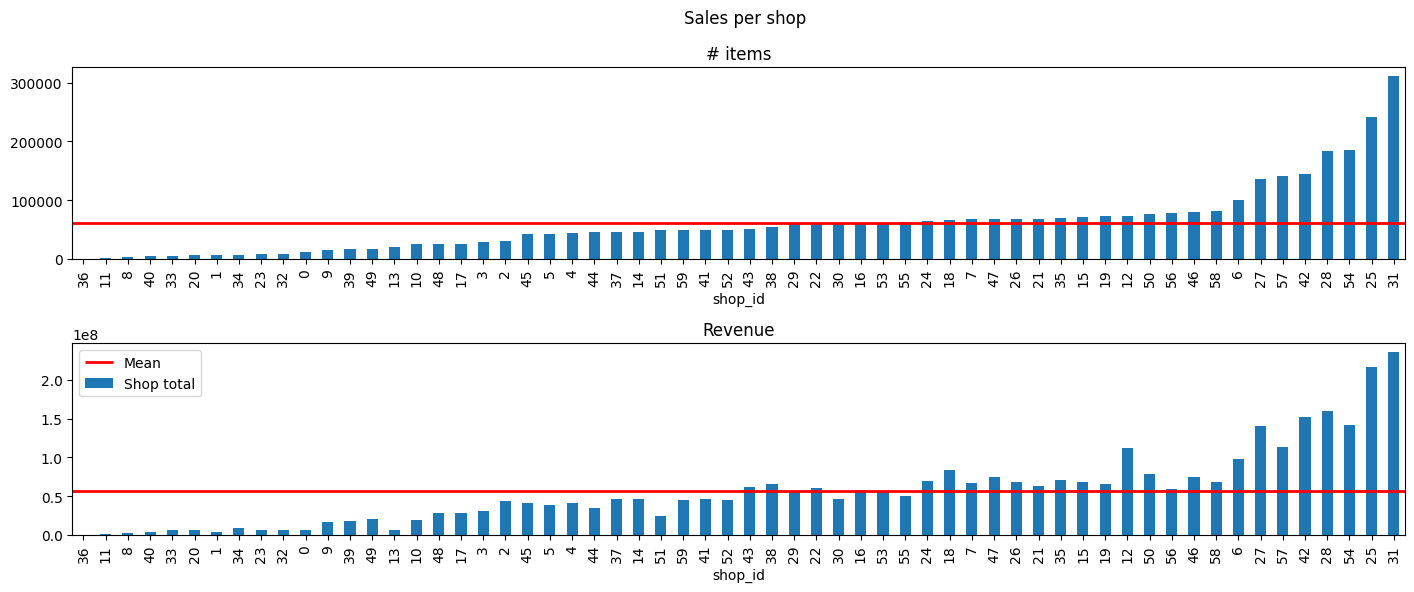

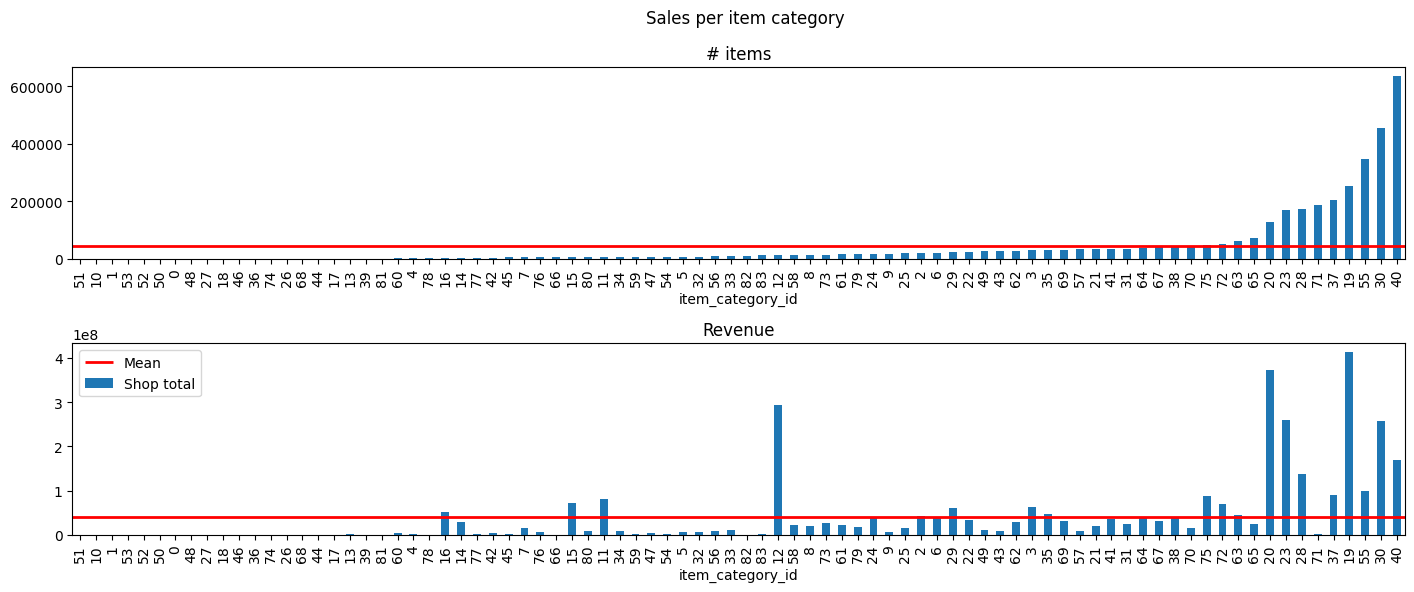

In [46]:
# Investigating shops/items
item_count_per_shop = sales_train.groupby("shop_id").nunique()['item_id']
item_count_per_shop.sort_values().plot.bar( figsize=(15,3),label= "Number of distinct items")
plt.title("Number of distinct items per shop")
plt.show()

measure = ['item_cnt_day', 'total_price']
title = ['# items', 'Revenue']
groups = {'shop_id':'shop', 'item_category_id':'item category'}

for group in groups:
    fig, ax = plt.subplots(2, 1, figsize=(15,6))
    for i in range(2):
        item_sells_count_per_shop = sales_train.groupby(group).sum()[measure[i]]
        ax[i].hlines( item_sells_count_per_shop.mean(), xmin=-1, xmax=100, linewidth=2, color='r',label='Mean')
        if i == 0:
            indices = item_sells_count_per_shop.argsort()
        item_sells_count_per_shop.iloc[indices].plot.bar(label= "Shop total", ax=ax[i])
        ax[i].set_title(title[i])
    fig.suptitle('Sales per ' + groups[group])
    fig.tight_layout(rect=[0,0,0.95,1])
    plt.legend()

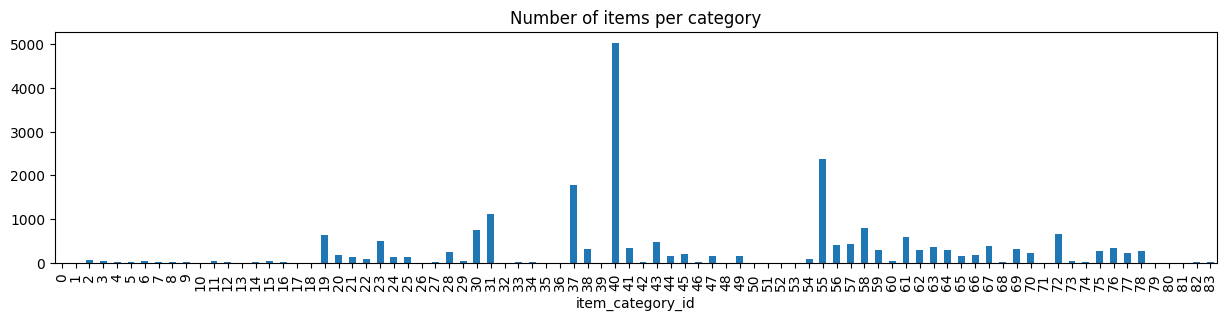

Items which are returned more than sold, or not sold at all:
         item_price  item_cnt_day  total_price
item_id                                       
1590        2599.00         -11.0     -28589.0
4591         399.00           0.0          0.0
7547        3390.00           0.0          0.0
8515         141.55           0.0         14.9
11871       5999.00          -1.0      -5999.0
13474      10398.00          -1.0     -10398.0
13477      10194.00           0.0      -7592.0
18062       4999.00          -1.0      -4999.0


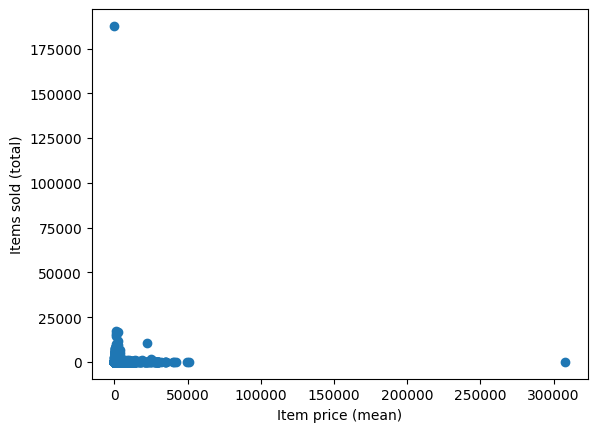

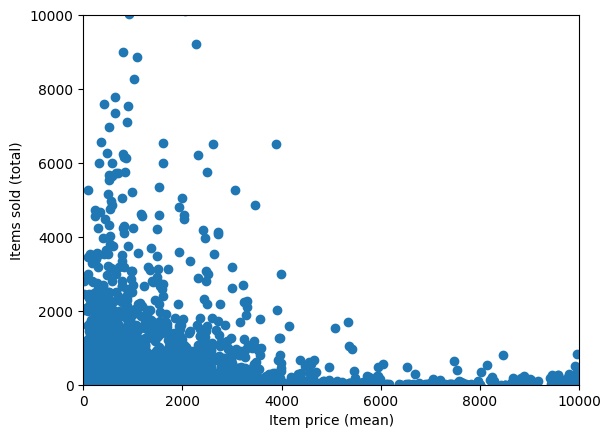

Corelation between item price and sales count:
              item_cnt_day  item_price
item_cnt_day      1.000000    0.004903
item_price        0.004903    1.000000


In [47]:
# More on items
aggregation = {'item_price':'mean', 'item_cnt_day':'sum', 'total_price':'sum'}
sales_per_item = pd.merge(items, sales_train, on='item_id').groupby('item_id').agg(aggregation)
items_per_categories = items.groupby('item_category_id').count()['item_name'].plot.bar(figsize=(15,3), title='Number of items per category')
plt.show()

print("Items which are returned more than sold, or not sold at all:")
print(sales_per_item[sales_per_item['item_cnt_day'] <= 0])

plt.scatter(sales_per_item['item_price'], sales_per_item['item_cnt_day'])
plt.xlabel('Item price (mean)')
plt.ylabel('Items sold (total)')
plt.show()

plt.scatter(sales_per_item['item_price'], sales_per_item['item_cnt_day'])
plt.xlabel('Item price (mean)')
plt.ylabel('Items sold (total)')
plt.xlim((0,10000))
plt.ylim((0,10000))
plt.show()

print("Corelation between item price and sales count:")
print(sales_per_item[['item_cnt_day', 'item_price']].corr())

We can't visualize per-item patterns as the matrix is too big. But we can do this for item category.

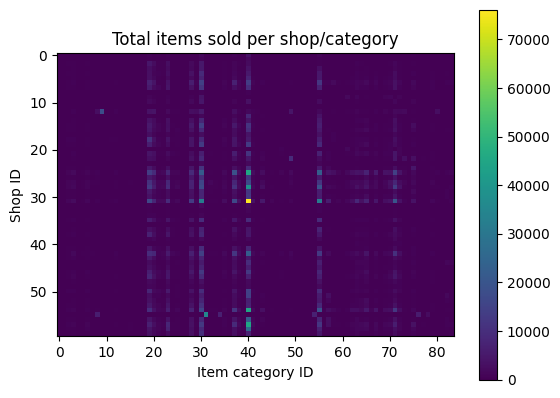

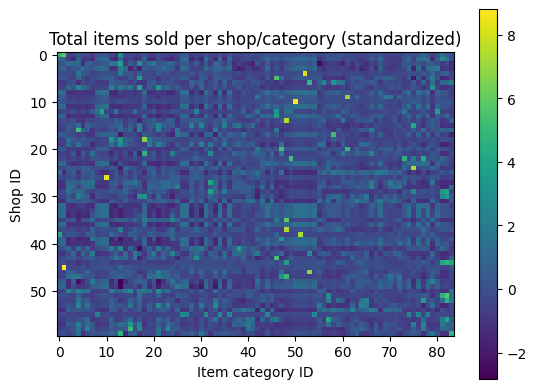

In [49]:
def standardize(matrix, cols=True, rows=True):
    if cols:
        col_mean = matrix.mean(axis=0)
        col_std = matrix.std(axis=0)
        matrix = (matrix - col_mean[np.newaxis, :]) / col_std[np.newaxis, :]
    if rows:
        row_mean = matrix.mean(axis=1)
        row_std = matrix.std(axis=1)
        matrix = (matrix - row_mean[:, np.newaxis]) / row_std[:, np.newaxis] 
    return matrix

shop_itemcat = sales_train.groupby(['shop_id', 'item_category_id'], as_index=False).sum()
mat = np.zeros((60, 84))
for i in range(60):
    for j in range(84):
        total_cnt = shop_itemcat[(shop_itemcat['shop_id']==i) & (shop_itemcat['item_category_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

settings = [[False, False, ''], 
            # [False, True, ' (categories standardized)'], 
            # [True, False, ' (shops standardized)'], 
            [True, True, ' (standardized)']]

for setting in settings:
    plt.imshow(standardize(mat.copy(), rows=setting[0], cols=setting[1]))
    plt.xlabel('Item category ID')
    plt.ylabel('Shop ID')
    plt.title('Total items sold per shop/category' + setting[2])
    plt.colorbar()
    plt.show()

# Seasonal patterns
We can use the same approach to detect some seasonal patterns.

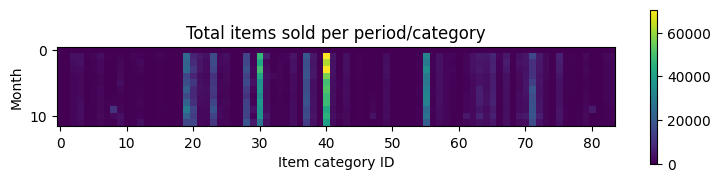

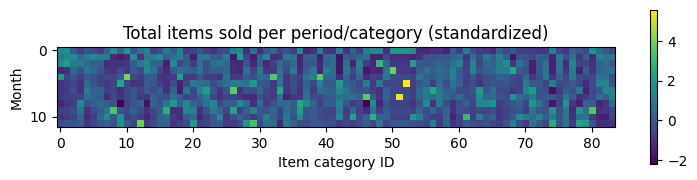

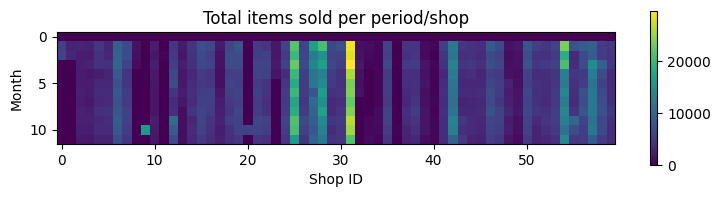

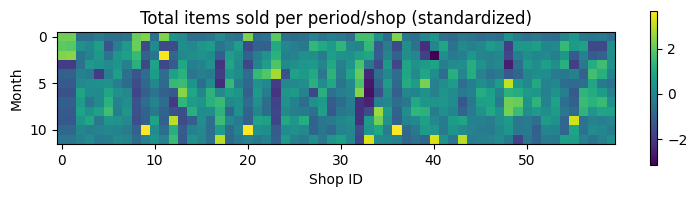

In [50]:
period_itemcat = sales_train.groupby(['month', 'item_category_id'], as_index=False).sum()
mat = np.zeros((12, 84))
for i in range(12):
    for j in range(84):
        total_cnt = period_itemcat[(period_itemcat['month']==i) & (period_itemcat['item_category_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

settings = [[False, False, ''], 
            # [False, True, ' (categories standardized)'], 
            # [True, False, ' (months standardized)'], 
            [True, True, ' (standardized)']]

for i in range(len(settings)):
    plt.figure(figsize=(9,2))
    plt.imshow(standardize(mat.copy(), rows=settings[i][0], cols=settings[i][1]))
    plt.xlabel('Item category ID')
    plt.ylabel("Month")
    plt.title("Total items sold per period/category" + settings[i][2])
    plt.colorbar()
    plt.show()

period_shop = sales_train.groupby(['month', 'shop_id'], as_index=False).sum()
mat = np.zeros((12, 60))
for i in range(12):
    for j in range(60):
        total_cnt = period_shop[(period_shop['month']==i) & (period_shop['shop_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

settings = [[False, False, ''], 
            # [False, True, ' (shops standardized)'], 
            # [True, False, ' (months standardized)'], 
            [True, True, ' (standardized)']]

for i in range(len(settings)):
    plt.figure(figsize=(9,2))
    plt.imshow(standardize(mat.copy(), rows=settings[i][0], cols=settings[i][1]))
    plt.xlabel('Shop ID')
    plt.ylabel("Month")
    plt.title("Total items sold per period/shop" + settings[i][2])
    plt.colorbar()
    plt.show()

Lowest item_cnt_day per year
          date  total_price  item_cnt_day  year  month  weekday
861 2015-05-12   1350036.00        1274.0  2015      5        2
497 2014-05-13   1334211.14        1629.0  2014      5        2
0   2013-01-01   1362942.00        1951.0  2013      1        2
Highest item_cnt_day per year
          date   total_price  item_cnt_day  year  month  weekday
361 2013-12-28  1.462670e+07       13343.0  2013     12        6
728 2014-12-30  1.700265e+07       13236.0  2014     12        2
868 2015-05-19  1.923574e+07        8483.0  2015      5        2
Lowest revenue per year
          date  total_price  item_cnt_day  year  month  weekday
132 2013-05-13   1194405.00        2075.0  2013      5        1
854 2015-05-05   1226029.36        1349.0  2015      5        2
497 2014-05-13   1334211.14        1629.0  2014      5        2
Highest revenue per year
          date   total_price  item_cnt_day  year  month  weekday
332 2013-11-29  3.654481e+07        7262.0  2013     11

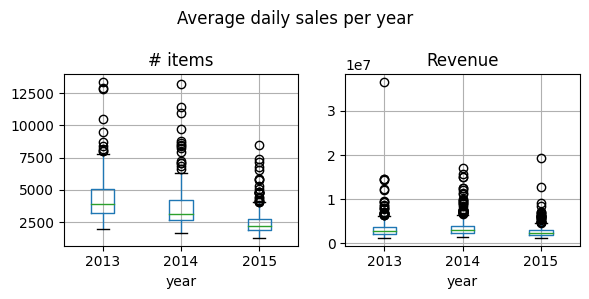

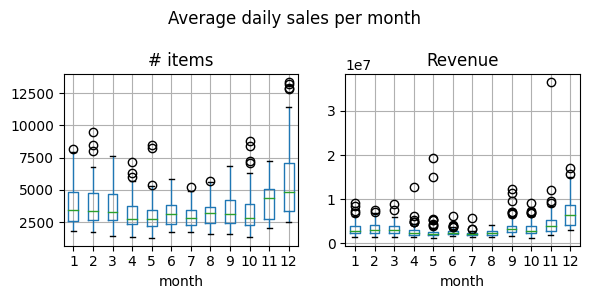

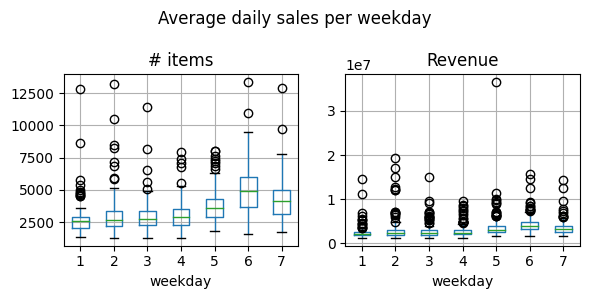

In [63]:
# The boxplots are better interpretable
aggregation = {'total_price':'sum', 'item_cnt_day':'sum', 'year':'first', 'month':'first', 'weekday':'first'}
sales_per_day = sales_train.groupby('date', as_index=False).agg(aggregation)
for period in ['year', 'month', 'weekday']:
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    sales_per_day.boxplot(by=period, column=['item_cnt_day'], ax=ax[0])
    sales_per_day.boxplot(by=period, column=['total_price'], ax=ax[1])
    ax[0].set_title('# items')
    ax[1].set_title('Revenue')
    print("Lowest item_cnt_day per " + period)
    lowest_cnt = sales_per_day.sort_values('item_cnt_day', ascending=True)
    lowest_cnt = lowest_cnt.groupby(period).head(1)
    print(lowest_cnt)
    print("Highest item_cnt_day per " + period)
    highest_cnt = sales_per_day.sort_values('item_cnt_day', ascending=False)
    highest_cnt = highest_cnt.groupby(period).head(1)
    print(highest_cnt)
    print("Lowest revenue per " + period)
    lowest_rev = sales_per_day.sort_values('total_price', ascending=True)
    lowest_rev = lowest_rev.groupby(period).head(1)
    print(lowest_rev)
    print("Highest revenue per " + period)
    highest_rev = sales_per_day.sort_values('total_price', ascending=False)
    highest_rev = highest_rev.groupby(period).head(1)
    print(highest_rev)
    fig.suptitle('Average daily sales per ' + period)
    fig.tight_layout(rect=[0,0,1,1])

c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  if sys.path[0] == "":
c:\Users\luukr\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  if sys.path[0] == "":
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


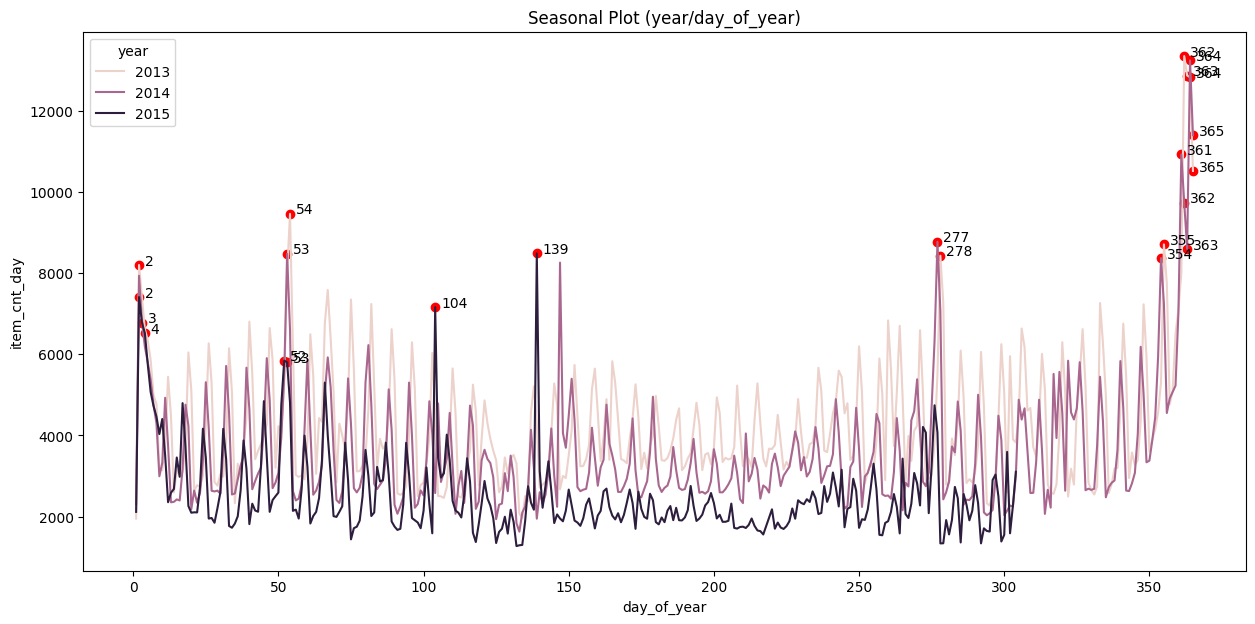

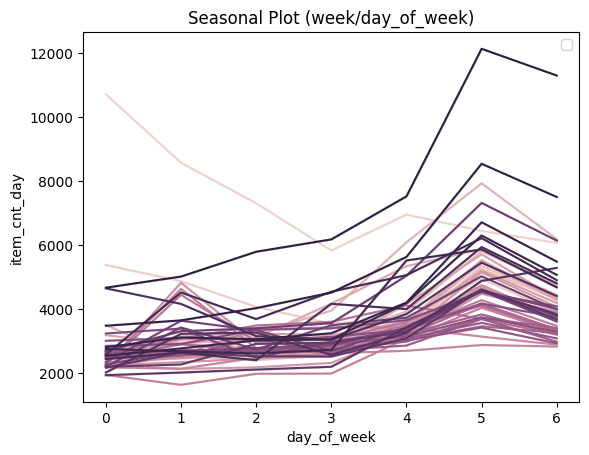

In [65]:
def seasonal_plot(X, y, period, freq, ax=None, legend = False):
    if ax is None:
        _, ax = plt.subplots()
        
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        legend = legend)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    return ax

# Sales for all shops daily summed
sales_daily = sales_train.groupby('date').sum()['item_cnt_day'].reset_index()

sales_daily['year'] = sales_daily['date'].dt.year
sales_daily['day_of_year'] = sales_daily['date'].dt.dayofyear

sales_daily['day_of_week'] = sales_daily['date'].dt.dayofweek
sales_daily['week'] = sales_daily['date'].dt.week


fig, ax = plt.subplots(figsize=(15,7))
seasonal_plot(sales_daily, y="item_cnt_day", period="week", freq="day_of_week")


high_values_yearly = sales_daily.groupby('year').quantile(q=0.98)['item_cnt_day']
high_dates = sales_daily[sales_daily.apply(lambda x:  x.item_cnt_day > high_values_yearly[x.year],axis=1)]

seasonal_plot(sales_daily, y="item_cnt_day", period="year", freq="day_of_year",ax=ax, legend = True)
ax.scatter(data=high_dates,x='day_of_year', y = 'item_cnt_day', c ='r',label='day of the high sales')

for idx, row in high_dates.iterrows():
    ax.annotate(str(row['day_of_year']), (row['day_of_year']+2, row['item_cnt_day'] + 4))

plt.legend()
plt.show()